In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit import ClassicalRegister, QuantumRegister, BasicAer
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq.job import job_monitor
provider = IBMQ.load_account()

/tmp/ipykernel_61/1809021497.py:14: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  provider = IBMQ.load_account()


# 3点曲げ試験結果の学習精度を上げる
学習精度の改善方法を考えていきます。改善する要素として
1. 入力データの量子状態への組み込み方法
2. パラメータ化量子回路の構成
3. 最適化アルゴリズムの選択

を考えていきます。

まず1について。調べたところ、論文
https://journals.aps.org/pra/abstract/10.1103/PhysRevA.98.032309
で行われている方法
$$
U_{\text{in}}(x_i) = \prod_j R_j^Z(\cos^{-1}(x^2))R_j^Y(\sin^{-1}(x))
$$
を用いたものが多かったので、これを採用します。

次に、2について。
https://arxiv.org/abs/1905.10876
によると、パラメータ化量子回路の性能は
- expressibility(ブロッホ球のカバー率)
- entangling capability(どれだけエンタングルされるか)
が影響しているようです。とりあえず、論文中のサンプルのうち、1層でもかなり高性能なcircuit6を実装します。

最後に、3について。これは今の方法(COBYLA?)が量子機械学習では主流らしいので、そのままで行きます。

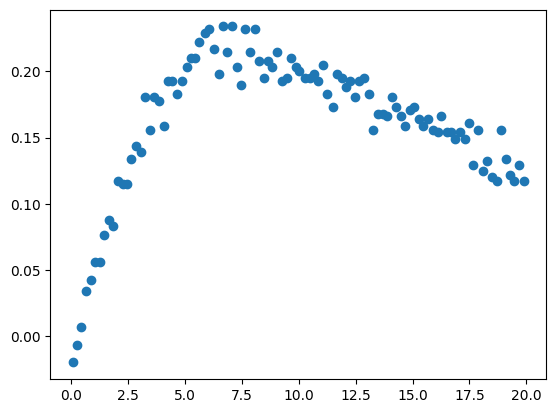

In [2]:

df = pd.read_excel('data.xlsx', sheet_name='board1', header=0)

# 時間について等間隔にn個の行を抽出
total_rows = len(df)
n = 100  # 抽出する行数
indices = np.linspace(0, total_rows - 1, n, dtype=int)
even_sample = df.iloc[indices]
load = even_sample['LOAD'].values
stroke = even_sample['STROKE'].values



plt.plot(stroke, load, "o"); plt.show()

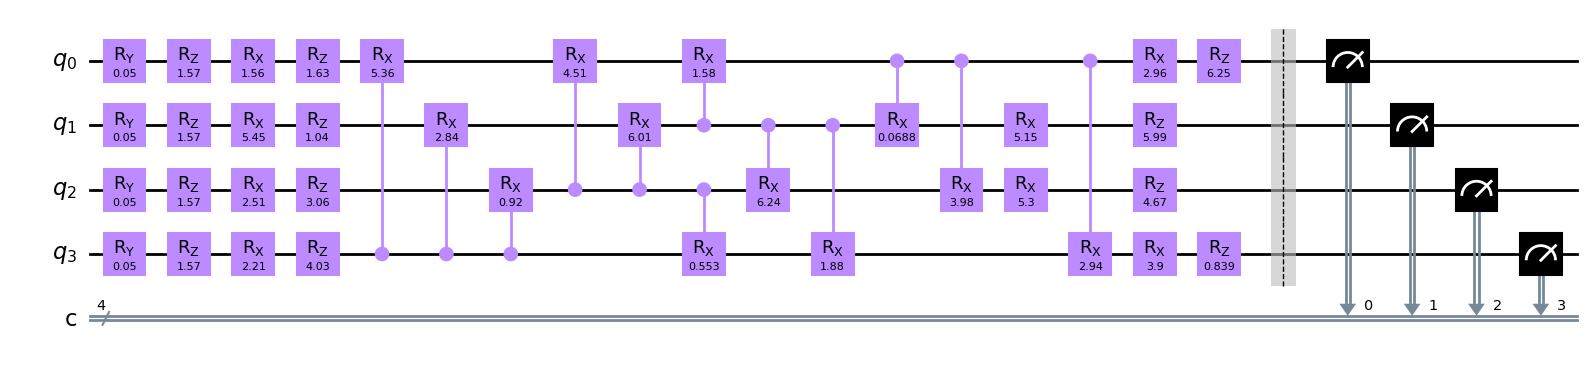

In [3]:
def input(circ, x):
#    theta = np.arcsin(2*x-1)
    theta = np.pi*x/20
    circ.ry(np.arcsin(x/20),range(4))
    circ.rz(np.arccos((x/20)**2),range(4))

def para_circ(circ, theta):
    for i in range(4):
        circ.rx(theta[i],i)
        circ.rz(theta[i+4],i)
    count = 8
    for i in range(3,-1,-1):
        for j in range(4):
            if i != j:
                circ.crx(theta[count],i,j)
                count+=1
    for i in range(4):
        circ.rx(theta[i+count],i)
        circ.rz(theta[i+4+count],i)

    
def qcirc(x,theta):
    qnum = 4 # number of qubits 
    cnum = 4 # number of classical bits for the measurement

    q = QuantumRegister(4, 'q')
    c = ClassicalRegister(4, 'c')

    circ = QuantumCircuit(q, c)
    meas = QuantumCircuit(q, c)

    input(circ,x)
    para_circ(circ,theta)

    meas.barrier()
    meas.measure(range(4),range(4))

    qc= circ.compose(meas)
    return qc

def predict(x,theta):
    qc=qcirc(x,theta)
    simulator = Aer.get_backend('qasm_simulator')
    job_sim = simulator.run(transpile(qc, simulator), shots=1024)
    result_sim = job_sim.result()
    counts = result_sim.get_counts(qc)
    total_count=sum(counts.values())
    sigma = sum(int(key, 2) * value / total_count for key, value in counts.items())
    y_pred = sigma/60
    return y_pred

def loss_eval(theta):
    y_pred = [predict(x,theta) for x in stroke] #内包表記
    L = ((y_pred - load)**2).mean()
    return L

qcirc(1,np.random.uniform(0, 2*np.pi, 28)).draw(output = 'mpl')

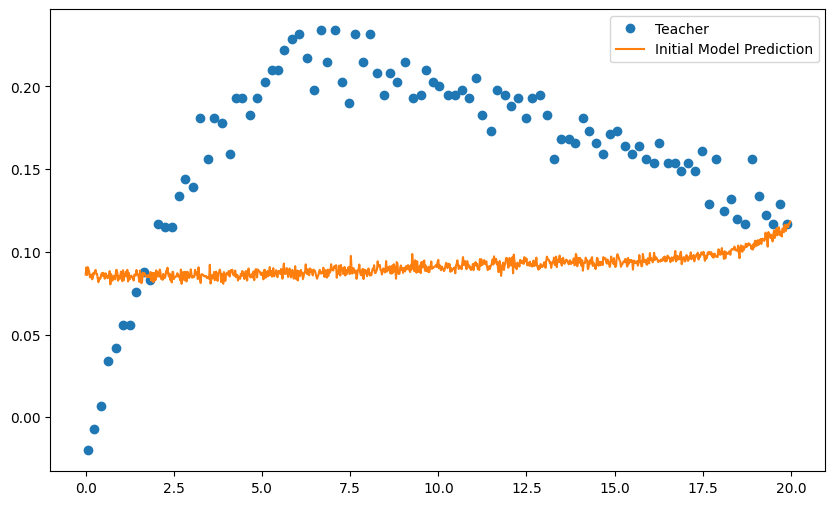

In [4]:
para_init=np.random.uniform(0, 2*np.pi, 28)

plt.figure(figsize=(10, 6))

x_min = 0
x_max = 20
xlist = np.arange(x_min, x_max, 0.02)
plt.plot(stroke, load, "o", label='Teacher')
y_init = [predict(x, para_init) for x in xlist]
plt.plot(xlist, y_init, label='Initial Model Prediction')

plt.legend()
plt.show()

In [5]:
x0=stroke[0]
y0=load[0]
qc=qcirc(x0,para_init)
qc.draw(output='mpl')
predict(x0,para_init)
loss_eval(para_init)

0.007817949723078409

In [6]:
from scipy.optimize import minimize
result = minimize(loss_eval, para_init, method='COBYLA')
# 最適化後のcost_functionの値
result.fun

0.0017923307799699575

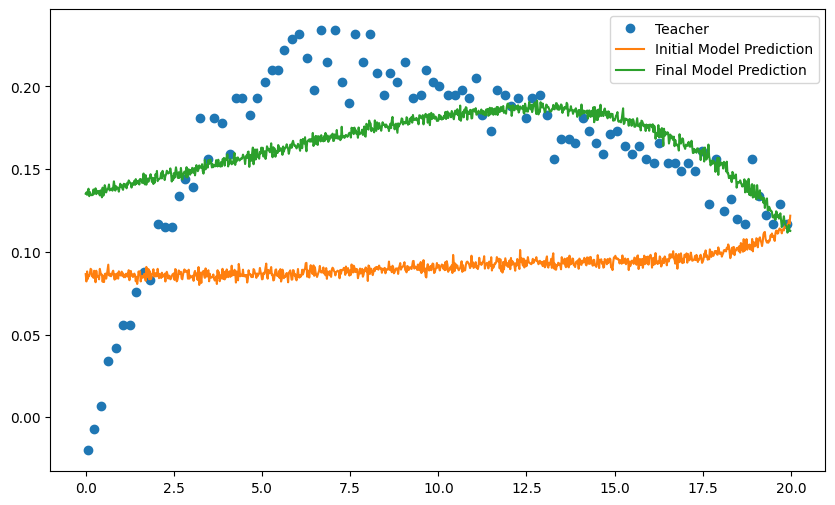

In [7]:
para_opt = result.x
# プロット
plt.figure(figsize=(10, 6))

xlist = np.arange(x_min, x_max, 0.02)

# 教師データ
plt.plot(stroke, load, "o", label='Teacher')

y_init = [predict(x, para_init) for x in xlist]
plt.plot(xlist, y_init, label='Initial Model Prediction')

# モデルの予測値
y_pred = np.array([predict(x, para_opt) for x in xlist])
plt.plot(xlist, y_pred, label='Final Model Prediction')

plt.legend()
plt.show()